In [14]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn import model_selection #методы разделения и валидации
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.metrics import f1_score
%matplotlib inline
plt.style.use('seaborn')

In [15]:
data = pd.read_csv('_train_sem09__1_.zip')

In [16]:
data.head(2)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0


Проверяем выборку на дисбаланс

Activity is 0: 45.77%
Activity is 1: 54.23%


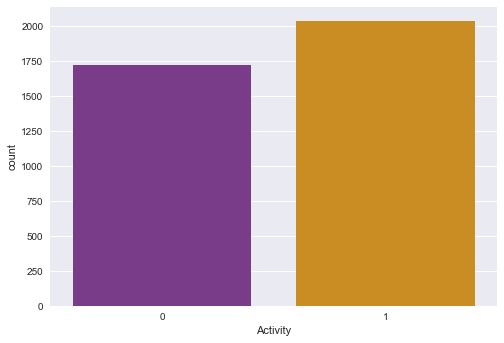

In [17]:
sns.countplot(data=data, x='Activity', palette='CMRmap')
activity_percent = data['Activity'].value_counts(normalize=True) * 100
print('Activity is 0: {:.2f}%'.format(activity_percent[0]))
print('Activity is 1: {:.2f}%'.format(activity_percent[1]))

Выборку можно считать сбалансированной.  
Разделим выборку на тренировочную и тестовую в соотношении 80/20.

In [18]:
X, y = data.drop('Activity', axis=1), data['Activity']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Оптимизация гиперпараметров модели

### **Логистическая регрессия**

Зафиксируем метрику F1-score, полученную без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [19]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(random_state=42, max_iter=50)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.78


c:\Users\Rui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### <center> **GridSearchCV**

Пробуем подобрать оптимальные параметры с помощью поиска по сетке

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'penalty': ['l1', 'l2', 'none'] , # тип регуляризации
              'solver': ['saga'], # алгоритм оптимизации
               'C': [0.01, 0.35, 0.7, 1]}, # уровень силы регуляризации
                {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'], 
               'C': [0.01, 0.35, 0.7, 1]}, 
               {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear'], 
               'C': [0.01, 0.35, 0.7, 1]}
             ]

grid_search_1 = GridSearchCV(
    estimator=log_reg, 
    param_grid=param_grid,
    scoring = 'f1', 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_1.fit(X_train, y_train) 
y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 3.42 s
Wall time: 53.5 s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.35, 'penalty': 'l1', 'solver': 'saga'}


c:\Users\Rui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [21]:
# Результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_1.cv_results_)
result_cv.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.566247,0.230019,0.020557,0.001625,0.01,l1,saga,"{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}",0.774691,0.773885,0.756672,0.745710,0.737679,0.757727,0.014808,31
1,3.207741,0.084760,0.020197,0.002444,0.01,l2,saga,"{'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}",0.815362,0.791988,0.769006,0.791728,0.765766,0.786770,0.018034,5


In [22]:
result_cv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_penalty', 'param_solver', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

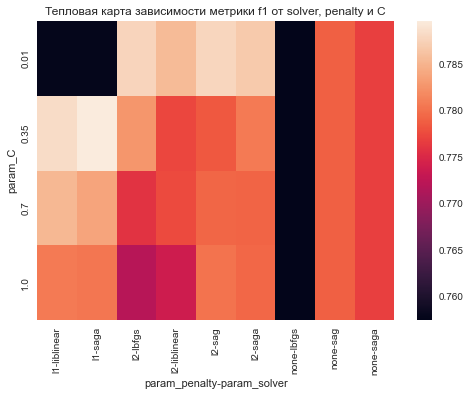

In [23]:
# Отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns=['param_penalty', 'param_solver'])
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики f1 от solver, penalty и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Изучим область предполагаемого максимума метрики подробнее с помощью новой сетки.

In [24]:
param_grid = {'penalty': ['l1'] , # тип регуляризации
              'solver': ['saga', 'liblinear'], # алгоритм оптимизации
               'C': [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]}, # уровень силы регуляризации
grid_search_2 = GridSearchCV(
    estimator=log_reg, 
    param_grid=param_grid,
    scoring = 'f1', 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_2.fit(X_train, y_train) 
y_test_pred = grid_search_2.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_2.best_params_))                

CPU times: total: 3.09 s
Wall time: 32.9 s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.2, 'penalty': 'l1', 'solver': 'saga'}


c:\Users\Rui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [25]:
# Результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_2.cv_results_)
result_cv.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.046076,0.015036,0.026692,0.001697,0.1,l1,saga,"{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}",0.807692,0.799392,0.78056,0.772660,0.766412,0.785343,0.015742,15
1,0.270175,0.020592,0.025792,0.002671,0.1,l1,liblinear,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.807122,0.804249,0.77037,0.773333,0.766412,0.784297,0.017624,16


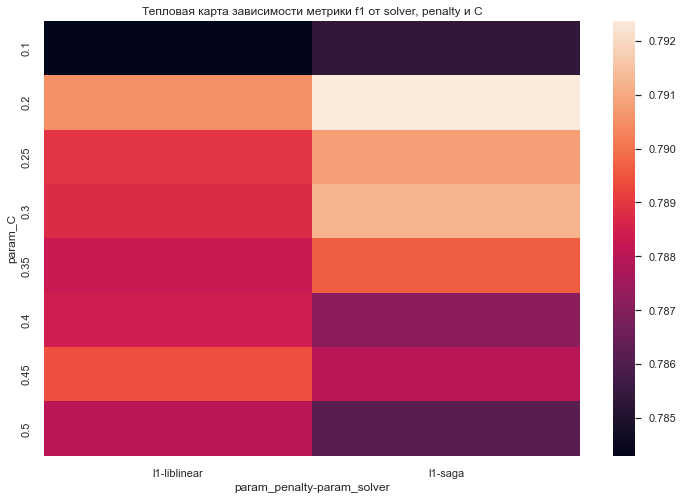

In [26]:
# Отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_2.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns=['param_penalty', 'param_solver'])
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики f1 от solver, penalty и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Значения метрики f1_score на тестовом наборе не изменились, комбинация внешних параметров лучше, чем заданы по умолчанию не найдена.

### <center> **RandomizedSearchCV**

Проведем поиск оптимальных параметров среди тех же значений, что и для GridSearchCV. Количество итераций выберем равным числу комбинаций параметров для GridSearchCV. Значительного выигрыша по времени не ожидается, но можно не использовать повторный поиск с более мелкой сеткой.

In [27]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = [{'penalty': ['l1', 'l2', 'none'] , 
              'solver': ['saga'], 
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}, 
                {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'], 
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}, 
               {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}]
            
random_search = RandomizedSearchCV(
    estimator=log_reg, 
    param_distributions=param_distributions,
    scoring = 'f1', 
    cv=5, 
    n_iter = 36, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 766 ms
Wall time: 59.7 s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.34}


Метрику f1_score на тестовом наборе улучшить не удалось.

### <center> **Hyperopt**

In [28]:
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

Настроим оптимизацию гиперпараметров для алгоритма логистической регрессии.

In [29]:
# зададим пространство поиска гиперпараметров

space = hp.choice('parameter_combinations', [
        {'solver': 'saga',
         'penalty': 'l1',
         'C': hp.uniform('C_saga_l1', 0.01, 1)
        },
        {'solver': 'saga',
         'penalty': 'l2',
         'C': hp.uniform('C_saga_l2', 0.01, 1)
        }, 
        {'solver': 'saga',
         'penalty': 'none',
         'C': hp.uniform('C_saga_none', 0.01, 1)
        }, 
         
         
        
        {'solver': 'lbfgs',
         'penalty':'l2',
         'C': hp.uniform('C_lbfgs_l2', 0.01, 1)
        },
        {'solver':'lbfgs',
         'penalty': 'none',
         'C': hp.uniform('C_lbfgs_none', 0.01, 1)
        },
        
        
        {'solver':'sag',
         'penalty': 'l2',
         'C': hp.uniform('C_sag_l2', 0.01, 1)
        },
        {'solver': 'sag',
         'penalty': 'none',
         'C': hp.uniform('C_sag_none', 0.01, 1)
        },
        
        
        {'solver': 'liblinear',
        'penalty': 'l1',
        'C': hp.uniform('C_liblinear_l1', 0.01, 1)
        },
        {'solver': 'liblinear',
        'penalty': 'l2',
        'C': hp.uniform('C_liblinear_l2', 0.01, 1)
        },
        ]
)

In [30]:
random_state = 42

def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    params = {'solver': params['solver'], 
              'penalty': params['penalty'], 
              'C': params['C']
             }
      
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter=50)

    # Обучаем модель с помощью кросс-валидации
    score = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()

    return -score

In [31]:
# начинаем подбор гиперпараметров
%time 
 
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
          )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 20/20 [00:55<00:00,  2.79s/trial, best loss: -0.787628046912189]
Наилучшие значения гиперпараметров {'C_saga_l2': 0.08292441519601887, 'parameter_combinations': 1}


In [32]:
# рассчитаем точность для тестовой выборки
model_HO_best = linear_model.LogisticRegression(
    solver = 'saga', 
    penalty = 'l2',
    C = 0.08292441519601887,
    random_state=random_state, 
    max_iter=50
    )
model_HO_best.fit(X_train, y_train)
y_train_pred = model_HO_best.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model_HO_best.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.85
f1_score на тестовом наборе: 0.79


c:\Users\Rui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


С помощью Hyperopt метрику f1_score на тестовом наборе удалось улучшить.

### <center> Optuna

In [33]:
import optuna

In [34]:
random_state = 42

def optuna_lr(trial):
    # пространство гиперпараметров
    solver = trial.suggest_categorical('solver', ['saga', 'lbfgs', 'sag', 'liblinear'])
    if solver == 'saga':
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'none'])
    else:
        penalty = 'l2'
        
    C = trial.suggest_uniform('C', 0.01, 1)
    
    model = linear_model.LogisticRegression(
        solver=solver,
        penalty=penalty,
        C=C,
        random_state=random_state, 
        max_iter=50
    )    
    
    # Обучаем модель с помощью кросс-валидации    
    score = cross_val_score(
        model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    
    return score

In [35]:
# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=random_state)
study_lr = optuna.create_study(
    sampler=sampler, study_name='LogisticRegression', direction='maximize')
study_lr.optimize(optuna_lr, n_trials=20)

[I 2022-08-26 16:19:12,948] A new study created in memory with name: LogisticRegression
[I 2022-08-26 16:19:14,064] Trial 0 finished with value: 0.7834178997770478 and parameters: {'solver': 'lbfgs', 'C': 0.16445845403801215}. Best is trial 0 with value: 0.7834178997770478.
[I 2022-08-26 16:19:17,170] Trial 1 finished with value: 0.7793051656527762 and parameters: {'solver': 'sag', 'C': 0.710991852018085}. Best is trial 0 with value: 0.7834178997770478.
[I 2022-08-26 16:19:18,381] Trial 2 finished with value: 0.7814287466066778 and parameters: {'solver': 'lbfgs', 'C': 0.19000671753502962}. Best is trial 0 with value: 0.7834178997770478.
[I 2022-08-26 16:19:21,697] Trial 3 finished with value: 0.7784773740869497 and parameters: {'solver': 'sag', 'C': 0.2983168487960615}. Best is trial 0 with value: 0.7834178997770478.
[I 2022-08-26 16:19:25,567] Trial 4 finished with value: 0.7796530883762236 and parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.5190920940294755}. Best is trial 0 w

In [36]:
# Модель с лучшими параметрами
optuna_lr = linear_model.LogisticRegression(
    **study_lr.best_params,  n_jobs=-1,
    random_state=random_state, max_iter=50
)
optuna_lr.fit(X_train, y_train)
y_train_pred = optuna_lr.predict(X_train)
y_test_pred = optuna_lr.predict(X_test)

c:\Users\Rui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


In [37]:
print(f'Наилучшие значения гиперпараметров: {study_lr.best_params}')
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'C': 0.029834922551910417}
f1_score на обучающем наборе: 0.84
f1_score на тестовом наборе: 0.78


С помощью Optuna метрику f1_score на тестовом наборе улучшить не удалось.

### **Случайный лес**

Проделаем аналогичные действия для RandomForestClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [38]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 1.00
f1_score на тестовом наборе: 0.80


### <center> **GridSearchCV**

In [39]:
# Сетка параметров
param_grid = {'n_estimators': list(range(100, 400, 100)),
              'min_samples_leaf': list(range(4, 10, 2)),
              'max_depth': list(np.linspace(5, 50, 10, dtype=int))
              }
# Поиск по сетке параметров с кросс-валидацией             
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 4.67 s
Wall time: 3min 50s
f1_score на обучающем наборе: 0.93
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 30, 'min_samples_leaf': 6, 'n_estimators': 300}


Значения метрики f1_score на тестовом наборе не изменились, комбинация внешних параметров лучше, чем заданы по умолчанию не найдена.

### <center> **RandomizedSearchCV**

Проведем поиск оптимальных параметров среди тех же значений, что и для GridSearchCV.

In [40]:
# Сетка параметров
param_distributions = {'n_estimators': list(range(100, 400, 100)),
              'min_samples_leaf': list(range(4, 10, 2)),
              'max_depth': list(np.linspace(5, 50, 10, dtype=int))
              }

# Поиск по сетке параметров с кросс-валидацией            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 20, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 3.06 s
Wall time: 48.2 s
f1_score на обучающем наборе: 0.93
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'n_estimators': 300, 'min_samples_leaf': 6, 'max_depth': 40}


Значения метрики f1_score на тестовом наборе не изменились, комбинация внешних параметров лучше, чем заданы по умолчанию не найдена.

### <center> **Hyperopt**

Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [41]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 400, 10),
       'max_depth' : hp.quniform('max_depth', 5, 50, 10),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 4, 10, 1)
      }

In [42]:
# зафиксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, 
                                            random_state=random_state,
                                            n_jobs=-1
                                            )

    
    # Обучаем модель с помощью кросс-валидации    
    score = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [43]:
# начинаем подбор гиперпараметров
%time 
 
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
          # rstate=np.random.default_rng(random_state)
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 20/20 [01:03<00:00,  3.20s/trial, best loss: -0.8124706654030968]
Наилучшие значения гиперпараметров {'max_depth': 20.0, 'min_samples_leaf': 4.0, 'n_estimators': 110.0}


In [44]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.96
f1_score на тестовом наборе: 0.80


Значения метрики f1_score на тестовом наборе не изменились, комбинация внешних параметров лучше, чем заданы по умолчанию не найдена.

### <center> Optuna

In [45]:
random_state = 42

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 400, 10)
    max_depth = trial.suggest_int('max_depth', 5, 50, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 4, 10, 1)

  # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          n_jobs=-1,
                                          random_state=random_state)
  # Обучаем модель с помощью кросс-валидации    
    score = cross_val_score(
        model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    return score

In [46]:
# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=random_state)
study_rf = optuna.create_study(
    sampler=sampler, study_name='RandomForestClassifier', direction='maximize')
study_rf.optimize(optuna_rf, n_trials=20)

[I 2022-08-26 16:25:34,197] A new study created in memory with name: RandomForestClassifier
c:\Users\Rui\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [5, 50] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 45].
  warnings.warn(
[I 2022-08-26 16:25:37,004] Trial 0 finished with value: 0.808715793761546 and parameters: {'n_estimators': 210, 'max_depth': 45, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.808715793761546.
c:\Users\Rui\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [5, 50] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 45].
  warnings.warn(
[I 2022-08-26 16:25:39,430] Trial 1 finished with value: 0.7661087259188779 and parameters: {'n_estimators': 280, 'max_depth': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.808715793

In [47]:
# Модель с лучшими параметрами  
optuna_rf = ensemble.RandomForestClassifier(
    **study_rf.best_params, class_weight='balanced', n_jobs=-1,
    random_state=random_state
)
optuna_rf.fit(X_train, y_train)
y_train_pred = optuna_rf.predict(X_train)
y_test_pred = optuna_rf.predict(X_test)

In [48]:
print(f'Наилучшие значения гиперпараметров: {study_rf.best_params}')
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров: {'n_estimators': 250, 'max_depth': 25, 'min_samples_leaf': 4}
f1_score на обучающем наборе: 0.96
f1_score на тестовом наборе: 0.80


Значения метрики f1_score на тестовом наборе не изменились, комбинация внешних параметров лучше, чем заданы по умолчанию не найдена.